# Libraries

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import *
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt

# DATA Import

In [2]:
df = pd.read_csv('d:/ds/ozone.csv')

In [3]:
df.ffill(inplace=True)

In [4]:
def rolling(df, size=6):
    windows = np.zeros(shape=(df.shape[0]-size+1, size, df.shape[-1]))
    start_index = [i for i in range(0, df.shape[0]-size+1)]
    end_index = [i+size for i in start_index]
    for i in range(len(start_index)):
        windows[i, :, :] = df.iloc[start_index[i]: end_index[i], :].values
    return windows

In [5]:
x = rolling(df.iloc[:, 1:])

In [6]:
y = x[:, -1, -1]
x = x[:, :, :-1]
y.shape = (-1, 1)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,  y_test = train_test_split(x, y, test_size=0.2, stratify=y)

# Component Implementation

In [8]:
class PositionEncoding(layers.Layer):
    def __init__(self, var_num, dropout=0.1, max_len=5000, **kwargs):
        super(PositionEncoding, self).__init__(**kwargs)
        self.dropout = layers.Dropout(rate=dropout)
        pe = tf.Variable(tf.zeros(shape=(max_len, var_num)), trainable=False)
        position = tf.cast(tf.expand_dims(tf.range(0, max_len), axis=1),
                           dtype=tf.float32)
        div_term = tf.exp(
            tf.cast(tf.range(0, var_num, 2), dtype=tf.float32) *
            -(tf.cast(math.log(10000.0) / var_num, dtype=tf.float32)))
        pe[:, 0::2].assign(tf.sin(position * div_term))
        pe[:, 1::2].assign(tf.cos(position * div_term))

        pe = tf.expand_dims(pe, axis=0)
        self.pe = tf.constant(pe)

    def call(self, x):
        x = x + self.pe[:, :x.shape[1]]
        return self.dropout(x)

In [9]:
def attention(query, key, value, dropout=None):
    var_num = query.shape[-1]
    scaled_scores = tf.matmul(query, tf.transpose(key, perm=[0, 1, 3, 2])) / math.sqrt(var_num)
    
    prob_attn = tf.nn.softmax(scaled_scores, axis=-1)
    
    return tf.matmul(prob_attn, value), prob_attn

In [10]:
def clones(layer, N):
    lys = [copy.deepcopy(layer) for _ in range(N)]
    assert all([lys[0].name == lys[i].name for i in range(N)])
    ori_name = lys[0].name
    new_name_ls = [ori_name + '_' + str(i) for i in range(N)]
    for i in range(N):
        lys[i]._name = new_name_ls[i]
    return lys

In [11]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, head, var_num, dropout=0.1, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        assert var_num % head == 0
        self.head_size = var_num // head
        self.head = head
        self.attn = None
        self.dropout = layers.Dropout(rate=dropout)
        
        self.query_ly = layers.Dense(var_num, trainable=True, name='query')
        self.key_ly = layers.Dense(var_num, trainable=True, name='key')
        self.value_ly = layers.Dense(var_num, trainable=True, name='value')
        self.concat_ly = layers.Dense(var_num, trainable=True, name='value')
        
        self.layernorm = layers.LayerNormalization(axis=-1, epsilon=1e-6)
        
    def call(self, state):
        batch_size = state.shape[0]
        
        query = tf.transpose(tf.reshape(self.query_ly(state), (batch_size, -1, self.head, self.head_size)), perm=[0, 2, 1, 3])
        key = tf.transpose(tf.reshape(self.key_ly(state), (batch_size, -1, self.head, self.head_size)), perm=[0, 2, 1, 3])
        value = tf.transpose(tf.reshape(self.value_ly(state), (batch_size, -1, self.head, self.head_size)), perm=[0, 2, 1, 3])
        
        x, self.attn = attention(query, key, value, dropout=self.dropout)
        x = tf.reshape(tf.transpose(x, perm=[0, 2, 1, 3]), shape=(batch_size, -1, self.head * self.head_size))
        x = self.concat_ly(x)
        x = self.layernorm(x)
        
        return state + self.dropout(x)

In [12]:
class FeedForward(layers.Layer):
    def __init__(self, var_num, d_ff, dropout=0.1, **kwargs):
        super(FeedForward, self).__init__(*kwargs)
        self.lin1 = layers.Dense(d_ff, trainable=True)
        self.lin2 = layers.Dense(var_num, trainable=True)
        self.dropout = layers.Dropout(rate=dropout)
        self.layernorm = layers.LayerNormalization(axis=-1, epsilon=1e-6)
        
    def call(self, x):
        ff_res = self.layernorm(self.dropout(self.lin2(self.dropout(tf.nn.relu(self.lin1(x))))))
        return x + ff_res

# Model Structure

In [13]:
seq_len = x_train.shape[1]
var_num = x_train.shape[-1]
batch_size = 64
head = 8
d_ff = 64
dropout = 0.2
cls_num = 1
N_enc = 1

In [14]:
attns = clones(MultiHeadSelfAttention(head, var_num, dropout), N_enc)
ffs = clones(FeedForward(var_num, d_ff, dropout), N_enc)
pos = PositionEncoding(var_num, dropout)

In [15]:
inputs = layers.Input(shape=(seq_len, var_num), batch_size=batch_size)
x = inputs + pos(inputs)
for ly in range(N_enc):
    x = attns[ly](x)
    x = ffs[ly](x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(d_ff)(x)
x = layers.Dropout(dropout)(x)
outputs = layers.Dense(cls_num, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(64, 6, 72)]        0                                            
__________________________________________________________________________________________________
position_encoding (PositionEnco (64, 6, 72)          0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_AddV2 (TensorFlowOp [(64, 6, 72)]        0           input_1[0][0]                    
                                                                 position_encoding[0][0]          
__________________________________________________________________________________________________
multi_head_self_attention_0 (Mu (64, 6, 72)          21168       tf_op_layer_AddV2[0][0

In [17]:
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train.reshape((-1, 1))))
dataset_train = dataset_train.batch(batch_size, drop_remainder=True)

In [18]:
dataset_val = tf.data.Dataset.from_tensor_slices((x_test, y_test.reshape((-1, 1))))
dataset_val = dataset_val.batch(batch_size, drop_remainder=True)

In [19]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='pr_auc', curve='PR'),
      keras.metrics.AUC(name='roc_auc', curve='ROC')
]

In [20]:
weight_for_0 = (1 / len(np.where(y_train==0)[0]))*(y_train.shape[0])/2.0 
weight_for_1 = (1 / len(np.where(y_train==1)[0]))*(y_train.shape[0])/2.0 

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 17.45


In [21]:
model.compile(optimizer=tf.optimizers.Adam(lr=0.00001), loss='binary_crossentropy', metrics=METRICS)
history = model.fit(dataset_train, epochs=600, validation_data=dataset_val, class_weight=class_weight)

Epoch 1/600
31/31 [==============================] - 1s 29ms/step - loss: 701.4816 - tp: 24.0000 - fp: 737.0000 - tn: 1190.0000 - fn: 33.0000 - accuracy: 0.6119 - precision: 0.0315 - recall: 0.4211 - pr_auc: 0.0299 - roc_auc: 0.5156 - val_loss: 11.4874 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 436.0000 - val_fn: 12.0000 - val_accuracy: 0.9732 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_pr_auc: 0.0268 - val_roc_auc: 0.5000
Epoch 2/600
31/31 [==============================] - 0s 8ms/step - loss: 680.0383 - tp: 20.0000 - fp: 783.0000 - tn: 1144.0000 - fn: 37.0000 - accuracy: 0.5867 - precision: 0.0249 - recall: 0.3509 - pr_auc: 0.0265 - roc_auc: 0.4724 - val_loss: 9.7289 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 436.0000 - val_fn: 12.0000 - val_accuracy: 0.9732 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_pr_auc: 0.0268 - val_roc_auc: 0.5000
Epoch 3/600
31/31 [==============================] - 0s 8ms/step - loss: 742.1880 - tp: 24.0000 - fp

31/31 [==============================] - 0s 8ms/step - loss: 727.3855 - tp: 30.0000 - fp: 964.0000 - tn: 963.0000 - fn: 27.0000 - accuracy: 0.5005 - precision: 0.0302 - recall: 0.5263 - pr_auc: 0.0298 - roc_auc: 0.5130 - val_loss: 1.0284 - val_tp: 3.0000 - val_fp: 16.0000 - val_tn: 420.0000 - val_fn: 9.0000 - val_accuracy: 0.9442 - val_precision: 0.1579 - val_recall: 0.2500 - val_pr_auc: 0.0566 - val_roc_auc: 0.5946
Epoch 20/600
31/31 [==============================] - 0s 8ms/step - loss: 783.0110 - tp: 24.0000 - fp: 875.0000 - tn: 1052.0000 - fn: 33.0000 - accuracy: 0.5423 - precision: 0.0267 - recall: 0.4211 - pr_auc: 0.0275 - roc_auc: 0.4834 - val_loss: 2.3929 - val_tp: 4.0000 - val_fp: 74.0000 - val_tn: 362.0000 - val_fn: 8.0000 - val_accuracy: 0.8170 - val_precision: 0.0513 - val_recall: 0.3333 - val_pr_auc: 0.0544 - val_roc_auc: 0.6802
Epoch 21/600
31/31 [==============================] - 0s 8ms/step - loss: 736.0275 - tp: 22.0000 - fp: 1001.0000 - tn: 926.0000 - fn: 35.0000 - ac

Epoch 38/600
31/31 [==============================] - 0s 8ms/step - loss: 708.7211 - tp: 27.0000 - fp: 967.0000 - tn: 960.0000 - fn: 30.0000 - accuracy: 0.4975 - precision: 0.0272 - recall: 0.4737 - pr_auc: 0.0277 - roc_auc: 0.4862 - val_loss: 1.7183 - val_tp: 4.0000 - val_fp: 51.0000 - val_tn: 385.0000 - val_fn: 8.0000 - val_accuracy: 0.8683 - val_precision: 0.0727 - val_recall: 0.3333 - val_pr_auc: 0.0503 - val_roc_auc: 0.5966
Epoch 39/600
31/31 [==============================] - 0s 8ms/step - loss: 610.7546 - tp: 28.0000 - fp: 939.0000 - tn: 988.0000 - fn: 29.0000 - accuracy: 0.5121 - precision: 0.0290 - recall: 0.4912 - pr_auc: 0.0289 - roc_auc: 0.5016 - val_loss: 5.6877 - val_tp: 7.0000 - val_fp: 118.0000 - val_tn: 318.0000 - val_fn: 5.0000 - val_accuracy: 0.7254 - val_precision: 0.0560 - val_recall: 0.5833 - val_pr_auc: 0.0524 - val_roc_auc: 0.6622
Epoch 40/600
31/31 [==============================] - 0s 8ms/step - loss: 661.7399 - tp: 30.0000 - fp: 960.0000 - tn: 967.0000 - fn: 

Epoch 57/600
31/31 [==============================] - 0s 8ms/step - loss: 586.7076 - tp: 31.0000 - fp: 929.0000 - tn: 998.0000 - fn: 26.0000 - accuracy: 0.5186 - precision: 0.0323 - recall: 0.5439 - pr_auc: 0.0313 - roc_auc: 0.5311 - val_loss: 6.3700 - val_tp: 7.0000 - val_fp: 122.0000 - val_tn: 314.0000 - val_fn: 5.0000 - val_accuracy: 0.7165 - val_precision: 0.0543 - val_recall: 0.5833 - val_pr_auc: 0.0513 - val_roc_auc: 0.6592
Epoch 58/600
31/31 [==============================] - 0s 8ms/step - loss: 732.3783 - tp: 26.0000 - fp: 958.0000 - tn: 969.0000 - fn: 31.0000 - accuracy: 0.5015 - precision: 0.0264 - recall: 0.4561 - pr_auc: 0.0272 - roc_auc: 0.4792 - val_loss: 12.9430 - val_tp: 10.0000 - val_fp: 165.0000 - val_tn: 271.0000 - val_fn: 2.0000 - val_accuracy: 0.6272 - val_precision: 0.0571 - val_recall: 0.8333 - val_pr_auc: 0.0464 - val_roc_auc: 0.6971
Epoch 59/600
31/31 [==============================] - 0s 8ms/step - loss: 504.5739 - tp: 34.0000 - fp: 959.0000 - tn: 968.0000 - f

Epoch 76/600
31/31 [==============================] - 0s 8ms/step - loss: 609.5209 - tp: 33.0000 - fp: 921.0000 - tn: 1006.0000 - fn: 24.0000 - accuracy: 0.5237 - precision: 0.0346 - recall: 0.5789 - pr_auc: 0.0331 - roc_auc: 0.5503 - val_loss: 8.0969 - val_tp: 7.0000 - val_fp: 132.0000 - val_tn: 304.0000 - val_fn: 5.0000 - val_accuracy: 0.6942 - val_precision: 0.0504 - val_recall: 0.5833 - val_pr_auc: 0.0457 - val_roc_auc: 0.6419
Epoch 77/600
31/31 [==============================] - 0s 8ms/step - loss: 731.4659 - tp: 22.0000 - fp: 925.0000 - tn: 1002.0000 - fn: 35.0000 - accuracy: 0.5161 - precision: 0.0232 - recall: 0.3860 - pr_auc: 0.0253 - roc_auc: 0.4529 - val_loss: 13.6652 - val_tp: 10.0000 - val_fp: 165.0000 - val_tn: 271.0000 - val_fn: 2.0000 - val_accuracy: 0.6272 - val_precision: 0.0571 - val_recall: 0.8333 - val_pr_auc: 0.0471 - val_roc_auc: 0.7003
Epoch 78/600
31/31 [==============================] - 0s 8ms/step - loss: 613.3082 - tp: 32.0000 - fp: 976.0000 - tn: 951.0000 -

Epoch 95/600
31/31 [==============================] - 0s 8ms/step - loss: 589.4442 - tp: 34.0000 - fp: 961.0000 - tn: 966.0000 - fn: 23.0000 - accuracy: 0.5040 - precision: 0.0342 - recall: 0.5965 - pr_auc: 0.0329 - roc_auc: 0.5497 - val_loss: 1.9851 - val_tp: 3.0000 - val_fp: 47.0000 - val_tn: 389.0000 - val_fn: 9.0000 - val_accuracy: 0.8750 - val_precision: 0.0600 - val_recall: 0.2500 - val_pr_auc: 0.0476 - val_roc_auc: 0.5991
Epoch 96/600
31/31 [==============================] - 0s 8ms/step - loss: 671.1230 - tp: 27.0000 - fp: 944.0000 - tn: 983.0000 - fn: 30.0000 - accuracy: 0.5091 - precision: 0.0278 - recall: 0.4737 - pr_auc: 0.0276 - roc_auc: 0.4875 - val_loss: 2.1079 - val_tp: 3.0000 - val_fp: 53.0000 - val_tn: 383.0000 - val_fn: 9.0000 - val_accuracy: 0.8616 - val_precision: 0.0536 - val_recall: 0.2500 - val_pr_auc: 0.0456 - val_roc_auc: 0.5937
Epoch 97/600
31/31 [==============================] - 0s 8ms/step - loss: 560.7151 - tp: 34.0000 - fp: 937.0000 - tn: 990.0000 - fn: 2

Epoch 114/600
31/31 [==============================] - 0s 8ms/step - loss: 848.1031 - tp: 23.0000 - fp: 959.0000 - tn: 968.0000 - fn: 34.0000 - accuracy: 0.4995 - precision: 0.0234 - recall: 0.4035 - pr_auc: 0.0254 - roc_auc: 0.4530 - val_loss: 9.1652 - val_tp: 7.0000 - val_fp: 134.0000 - val_tn: 302.0000 - val_fn: 5.0000 - val_accuracy: 0.6897 - val_precision: 0.0496 - val_recall: 0.5833 - val_pr_auc: 0.0469 - val_roc_auc: 0.6685
Epoch 115/600
31/31 [==============================] - 0s 8ms/step - loss: 672.7265 - tp: 28.0000 - fp: 999.0000 - tn: 928.0000 - fn: 29.0000 - accuracy: 0.4819 - precision: 0.0273 - recall: 0.4912 - pr_auc: 0.0277 - roc_auc: 0.4863 - val_loss: 12.6532 - val_tp: 8.0000 - val_fp: 152.0000 - val_tn: 284.0000 - val_fn: 4.0000 - val_accuracy: 0.6518 - val_precision: 0.0500 - val_recall: 0.6667 - val_pr_auc: 0.0485 - val_roc_auc: 0.6896
Epoch 116/600
31/31 [==============================] - 0s 8ms/step - loss: 640.9434 - tp: 27.0000 - fp: 938.0000 - tn: 989.0000 -

Epoch 133/600
31/31 [==============================] - 0s 8ms/step - loss: 579.7127 - tp: 33.0000 - fp: 940.0000 - tn: 987.0000 - fn: 24.0000 - accuracy: 0.5141 - precision: 0.0339 - recall: 0.5789 - pr_auc: 0.0326 - roc_auc: 0.5458 - val_loss: 16.1548 - val_tp: 10.0000 - val_fp: 162.0000 - val_tn: 274.0000 - val_fn: 2.0000 - val_accuracy: 0.6339 - val_precision: 0.0581 - val_recall: 0.8333 - val_pr_auc: 0.0471 - val_roc_auc: 0.7018
Epoch 134/600
31/31 [==============================] - 0s 8ms/step - loss: 572.5291 - tp: 30.0000 - fp: 979.0000 - tn: 948.0000 - fn: 27.0000 - accuracy: 0.4929 - precision: 0.0297 - recall: 0.5263 - pr_auc: 0.0295 - roc_auc: 0.5091 - val_loss: 10.0890 - val_tp: 7.0000 - val_fp: 135.0000 - val_tn: 301.0000 - val_fn: 5.0000 - val_accuracy: 0.6875 - val_precision: 0.0493 - val_recall: 0.5833 - val_pr_auc: 0.0470 - val_roc_auc: 0.6689
Epoch 135/600
31/31 [==============================] - 0s 8ms/step - loss: 482.5198 - tp: 38.0000 - fp: 893.0000 - tn: 1034.000

Epoch 152/600
31/31 [==============================] - 0s 8ms/step - loss: 546.9263 - tp: 34.0000 - fp: 951.0000 - tn: 976.0000 - fn: 23.0000 - accuracy: 0.5091 - precision: 0.0345 - recall: 0.5965 - pr_auc: 0.0331 - roc_auc: 0.5514 - val_loss: 5.5530 - val_tp: 7.0000 - val_fp: 91.0000 - val_tn: 345.0000 - val_fn: 5.0000 - val_accuracy: 0.7857 - val_precision: 0.0714 - val_recall: 0.5833 - val_pr_auc: 0.0606 - val_roc_auc: 0.6841
Epoch 153/600
31/31 [==============================] - 0s 8ms/step - loss: 560.2899 - tp: 29.0000 - fp: 954.0000 - tn: 973.0000 - fn: 28.0000 - accuracy: 0.5050 - precision: 0.0295 - recall: 0.5088 - pr_auc: 0.0293 - roc_auc: 0.5070 - val_loss: 4.2687 - val_tp: 7.0000 - val_fp: 81.0000 - val_tn: 355.0000 - val_fn: 5.0000 - val_accuracy: 0.8080 - val_precision: 0.0795 - val_recall: 0.5833 - val_pr_auc: 0.0640 - val_roc_auc: 0.6961
Epoch 154/600
31/31 [==============================] - 0s 8ms/step - loss: 710.6922 - tp: 25.0000 - fp: 961.0000 - tn: 966.0000 - fn

Epoch 171/600
31/31 [==============================] - 0s 8ms/step - loss: 551.5897 - tp: 32.0000 - fp: 950.0000 - tn: 977.0000 - fn: 25.0000 - accuracy: 0.5086 - precision: 0.0326 - recall: 0.5614 - pr_auc: 0.0316 - roc_auc: 0.5341 - val_loss: 20.6936 - val_tp: 11.0000 - val_fp: 176.0000 - val_tn: 260.0000 - val_fn: 1.0000 - val_accuracy: 0.6049 - val_precision: 0.0588 - val_recall: 0.9167 - val_pr_auc: 0.0556 - val_roc_auc: 0.7503
Epoch 172/600
31/31 [==============================] - 0s 8ms/step - loss: 462.0551 - tp: 40.0000 - fp: 907.0000 - tn: 1020.0000 - fn: 17.0000 - accuracy: 0.5343 - precision: 0.0422 - recall: 0.7018 - pr_auc: 0.0398 - roc_auc: 0.6156 - val_loss: 6.4514 - val_tp: 7.0000 - val_fp: 101.0000 - val_tn: 335.0000 - val_fn: 5.0000 - val_accuracy: 0.7634 - val_precision: 0.0648 - val_recall: 0.5833 - val_pr_auc: 0.0570 - val_roc_auc: 0.6765
Epoch 173/600
31/31 [==============================] - 0s 8ms/step - loss: 657.7537 - tp: 25.0000 - fp: 930.0000 - tn: 997.0000

Epoch 190/600
31/31 [==============================] - 0s 8ms/step - loss: 563.8185 - tp: 33.0000 - fp: 965.0000 - tn: 962.0000 - fn: 24.0000 - accuracy: 0.5015 - precision: 0.0331 - recall: 0.5789 - pr_auc: 0.0314 - roc_auc: 0.5348 - val_loss: 10.9957 - val_tp: 7.0000 - val_fp: 134.0000 - val_tn: 302.0000 - val_fn: 5.0000 - val_accuracy: 0.6897 - val_precision: 0.0496 - val_recall: 0.5833 - val_pr_auc: 0.0477 - val_roc_auc: 0.6719
Epoch 191/600
31/31 [==============================] - 0s 8ms/step - loss: 502.4391 - tp: 35.0000 - fp: 945.0000 - tn: 982.0000 - fn: 22.0000 - accuracy: 0.5126 - precision: 0.0357 - recall: 0.6140 - pr_auc: 0.0340 - roc_auc: 0.5616 - val_loss: 6.9409 - val_tp: 7.0000 - val_fp: 103.0000 - val_tn: 333.0000 - val_fn: 5.0000 - val_accuracy: 0.7589 - val_precision: 0.0636 - val_recall: 0.5833 - val_pr_auc: 0.0565 - val_roc_auc: 0.6754
Epoch 192/600
31/31 [==============================] - 0s 8ms/step - loss: 493.7504 - tp: 36.0000 - fp: 946.0000 - tn: 981.0000 -

Epoch 209/600
31/31 [==============================] - 0s 8ms/step - loss: 590.5801 - tp: 32.0000 - fp: 921.0000 - tn: 1006.0000 - fn: 25.0000 - accuracy: 0.5232 - precision: 0.0336 - recall: 0.5614 - pr_auc: 0.0323 - roc_auc: 0.5417 - val_loss: 2.0348 - val_tp: 3.0000 - val_fp: 37.0000 - val_tn: 399.0000 - val_fn: 9.0000 - val_accuracy: 0.8973 - val_precision: 0.0750 - val_recall: 0.2500 - val_pr_auc: 0.0500 - val_roc_auc: 0.5794
Epoch 210/600
31/31 [==============================] - 0s 8ms/step - loss: 555.3220 - tp: 28.0000 - fp: 901.0000 - tn: 1026.0000 - fn: 29.0000 - accuracy: 0.5312 - precision: 0.0301 - recall: 0.4912 - pr_auc: 0.0292 - roc_auc: 0.5079 - val_loss: 3.2980 - val_tp: 5.0000 - val_fp: 60.0000 - val_tn: 376.0000 - val_fn: 7.0000 - val_accuracy: 0.8504 - val_precision: 0.0769 - val_recall: 0.4167 - val_pr_auc: 0.0510 - val_roc_auc: 0.6618
Epoch 211/600
31/31 [==============================] - 0s 8ms/step - loss: 498.0289 - tp: 29.0000 - fp: 932.0000 - tn: 995.0000 - 

Epoch 228/600
31/31 [==============================] - 0s 8ms/step - loss: 541.3804 - tp: 33.0000 - fp: 941.0000 - tn: 986.0000 - fn: 24.0000 - accuracy: 0.5136 - precision: 0.0339 - recall: 0.5789 - pr_auc: 0.0328 - roc_auc: 0.5498 - val_loss: 6.8801 - val_tp: 7.0000 - val_fp: 97.0000 - val_tn: 339.0000 - val_fn: 5.0000 - val_accuracy: 0.7723 - val_precision: 0.0673 - val_recall: 0.5833 - val_pr_auc: 0.0592 - val_roc_auc: 0.6835
Epoch 229/600
31/31 [==============================] - 0s 8ms/step - loss: 637.3587 - tp: 26.0000 - fp: 912.0000 - tn: 1015.0000 - fn: 31.0000 - accuracy: 0.5247 - precision: 0.0277 - recall: 0.4561 - pr_auc: 0.0281 - roc_auc: 0.4914 - val_loss: 9.0016 - val_tp: 7.0000 - val_fp: 117.0000 - val_tn: 319.0000 - val_fn: 5.0000 - val_accuracy: 0.7277 - val_precision: 0.0565 - val_recall: 0.5833 - val_pr_auc: 0.0507 - val_roc_auc: 0.6620
Epoch 230/600
31/31 [==============================] - 0s 8ms/step - loss: 739.0027 - tp: 24.0000 - fp: 951.0000 - tn: 976.0000 - 

Epoch 247/600
31/31 [==============================] - 0s 8ms/step - loss: 490.9039 - tp: 35.0000 - fp: 950.0000 - tn: 977.0000 - fn: 22.0000 - accuracy: 0.5101 - precision: 0.0355 - recall: 0.6140 - pr_auc: 0.0339 - roc_auc: 0.5601 - val_loss: 34.0048 - val_tp: 11.0000 - val_fp: 200.0000 - val_tn: 236.0000 - val_fn: 1.0000 - val_accuracy: 0.5513 - val_precision: 0.0521 - val_recall: 0.9167 - val_pr_auc: 0.0517 - val_roc_auc: 0.7327
Epoch 248/600
31/31 [==============================] - 0s 8ms/step - loss: 549.1616 - tp: 33.0000 - fp: 968.0000 - tn: 959.0000 - fn: 24.0000 - accuracy: 0.5000 - precision: 0.0330 - recall: 0.5789 - pr_auc: 0.0319 - roc_auc: 0.5383 - val_loss: 21.4082 - val_tp: 10.0000 - val_fp: 161.0000 - val_tn: 275.0000 - val_fn: 2.0000 - val_accuracy: 0.6362 - val_precision: 0.0585 - val_recall: 0.8333 - val_pr_auc: 0.0536 - val_roc_auc: 0.7451
Epoch 249/600
31/31 [==============================] - 0s 8ms/step - loss: 578.4111 - tp: 29.0000 - fp: 919.0000 - tn: 1008.00

Epoch 266/600
31/31 [==============================] - 0s 8ms/step - loss: 622.6340 - tp: 27.0000 - fp: 987.0000 - tn: 940.0000 - fn: 30.0000 - accuracy: 0.4874 - precision: 0.0266 - recall: 0.4737 - pr_auc: 0.0275 - roc_auc: 0.4849 - val_loss: 21.4066 - val_tp: 10.0000 - val_fp: 159.0000 - val_tn: 277.0000 - val_fn: 2.0000 - val_accuracy: 0.6406 - val_precision: 0.0592 - val_recall: 0.8333 - val_pr_auc: 0.0521 - val_roc_auc: 0.7214
Epoch 267/600
31/31 [==============================] - 0s 8ms/step - loss: 591.3480 - tp: 26.0000 - fp: 953.0000 - tn: 974.0000 - fn: 31.0000 - accuracy: 0.5040 - precision: 0.0266 - recall: 0.4561 - pr_auc: 0.0273 - roc_auc: 0.4809 - val_loss: 24.4604 - val_tp: 11.0000 - val_fp: 167.0000 - val_tn: 269.0000 - val_fn: 1.0000 - val_accuracy: 0.6250 - val_precision: 0.0618 - val_recall: 0.9167 - val_pr_auc: 0.0560 - val_roc_auc: 0.7531
Epoch 268/600
31/31 [==============================] - 0s 8ms/step - loss: 519.4581 - tp: 31.0000 - fp: 923.0000 - tn: 1004.00

Epoch 285/600
31/31 [==============================] - 0s 8ms/step - loss: 496.9673 - tp: 28.0000 - fp: 953.0000 - tn: 974.0000 - fn: 29.0000 - accuracy: 0.5050 - precision: 0.0285 - recall: 0.4912 - pr_auc: 0.0288 - roc_auc: 0.5030 - val_loss: 32.1998 - val_tp: 11.0000 - val_fp: 190.0000 - val_tn: 246.0000 - val_fn: 1.0000 - val_accuracy: 0.5737 - val_precision: 0.0547 - val_recall: 0.9167 - val_pr_auc: 0.0540 - val_roc_auc: 0.7430
Epoch 286/600
31/31 [==============================] - 0s 8ms/step - loss: 612.4696 - tp: 30.0000 - fp: 958.0000 - tn: 969.0000 - fn: 27.0000 - accuracy: 0.5035 - precision: 0.0304 - recall: 0.5263 - pr_auc: 0.0299 - roc_auc: 0.5146 - val_loss: 33.5876 - val_tp: 11.0000 - val_fp: 196.0000 - val_tn: 240.0000 - val_fn: 1.0000 - val_accuracy: 0.5603 - val_precision: 0.0531 - val_recall: 0.9167 - val_pr_auc: 0.0534 - val_roc_auc: 0.7404
Epoch 287/600
31/31 [==============================] - 0s 8ms/step - loss: 519.7872 - tp: 32.0000 - fp: 952.0000 - tn: 975.000

Epoch 304/600
31/31 [==============================] - 0s 9ms/step - loss: 459.9455 - tp: 35.0000 - fp: 925.0000 - tn: 1002.0000 - fn: 22.0000 - accuracy: 0.5227 - precision: 0.0365 - recall: 0.6140 - pr_auc: 0.0347 - roc_auc: 0.5673 - val_loss: 3.6034 - val_tp: 4.0000 - val_fp: 57.0000 - val_tn: 379.0000 - val_fn: 8.0000 - val_accuracy: 0.8549 - val_precision: 0.0656 - val_recall: 0.3333 - val_pr_auc: 0.0470 - val_roc_auc: 0.6304
Epoch 305/600
31/31 [==============================] - 0s 8ms/step - loss: 514.9709 - tp: 32.0000 - fp: 914.0000 - tn: 1013.0000 - fn: 25.0000 - accuracy: 0.5267 - precision: 0.0338 - recall: 0.5614 - pr_auc: 0.0325 - roc_auc: 0.5439 - val_loss: 2.0510 - val_tp: 3.0000 - val_fp: 25.0000 - val_tn: 411.0000 - val_fn: 9.0000 - val_accuracy: 0.9241 - val_precision: 0.1071 - val_recall: 0.2500 - val_pr_auc: 0.0575 - val_roc_auc: 0.5889
Epoch 306/600
31/31 [==============================] - 0s 8ms/step - loss: 580.5181 - tp: 28.0000 - fp: 867.0000 - tn: 1060.0000 -

Epoch 323/600
31/31 [==============================] - 0s 8ms/step - loss: 505.4651 - tp: 32.0000 - fp: 932.0000 - tn: 995.0000 - fn: 25.0000 - accuracy: 0.5176 - precision: 0.0332 - recall: 0.5614 - pr_auc: 0.0320 - roc_auc: 0.5393 - val_loss: 16.5364 - val_tp: 8.0000 - val_fp: 139.0000 - val_tn: 297.0000 - val_fn: 4.0000 - val_accuracy: 0.6808 - val_precision: 0.0544 - val_recall: 0.6667 - val_pr_auc: 0.0485 - val_roc_auc: 0.6732
Epoch 324/600
31/31 [==============================] - 0s 8ms/step - loss: 576.8719 - tp: 26.0000 - fp: 947.0000 - tn: 980.0000 - fn: 31.0000 - accuracy: 0.5071 - precision: 0.0267 - recall: 0.4561 - pr_auc: 0.0274 - roc_auc: 0.4827 - val_loss: 16.3839 - val_tp: 8.0000 - val_fp: 139.0000 - val_tn: 297.0000 - val_fn: 4.0000 - val_accuracy: 0.6808 - val_precision: 0.0544 - val_recall: 0.6667 - val_pr_auc: 0.0488 - val_roc_auc: 0.6739
Epoch 325/600
31/31 [==============================] - 0s 8ms/step - loss: 471.5664 - tp: 30.0000 - fp: 968.0000 - tn: 959.0000 

Epoch 342/600
31/31 [==============================] - 0s 8ms/step - loss: 565.5724 - tp: 29.0000 - fp: 916.0000 - tn: 1011.0000 - fn: 28.0000 - accuracy: 0.5242 - precision: 0.0307 - recall: 0.5088 - pr_auc: 0.0301 - roc_auc: 0.5167 - val_loss: 28.5267 - val_tp: 11.0000 - val_fp: 171.0000 - val_tn: 265.0000 - val_fn: 1.0000 - val_accuracy: 0.6161 - val_precision: 0.0604 - val_recall: 0.9167 - val_pr_auc: 0.0558 - val_roc_auc: 0.7520
Epoch 343/600
31/31 [==============================] - 0s 8ms/step - loss: 497.3748 - tp: 35.0000 - fp: 970.0000 - tn: 957.0000 - fn: 22.0000 - accuracy: 0.5000 - precision: 0.0348 - recall: 0.6140 - pr_auc: 0.0334 - roc_auc: 0.5555 - val_loss: 16.3052 - val_tp: 8.0000 - val_fp: 139.0000 - val_tn: 297.0000 - val_fn: 4.0000 - val_accuracy: 0.6808 - val_precision: 0.0544 - val_recall: 0.6667 - val_pr_auc: 0.0496 - val_roc_auc: 0.6774
Epoch 344/600
31/31 [==============================] - 0s 8ms/step - loss: 479.0781 - tp: 30.0000 - fp: 931.0000 - tn: 996.000

Epoch 361/600
31/31 [==============================] - 0s 8ms/step - loss: 466.3065 - tp: 31.0000 - fp: 916.0000 - tn: 1011.0000 - fn: 26.0000 - accuracy: 0.5252 - precision: 0.0327 - recall: 0.5439 - pr_auc: 0.0317 - roc_auc: 0.5348 - val_loss: 19.9808 - val_tp: 9.0000 - val_fp: 145.0000 - val_tn: 291.0000 - val_fn: 3.0000 - val_accuracy: 0.6696 - val_precision: 0.0584 - val_recall: 0.7500 - val_pr_auc: 0.0494 - val_roc_auc: 0.6957
Epoch 362/600
31/31 [==============================] - 0s 8ms/step - loss: 481.5635 - tp: 26.0000 - fp: 926.0000 - tn: 1001.0000 - fn: 31.0000 - accuracy: 0.5176 - precision: 0.0273 - recall: 0.4561 - pr_auc: 0.0278 - roc_auc: 0.4875 - val_loss: 24.5166 - val_tp: 9.0000 - val_fp: 159.0000 - val_tn: 277.0000 - val_fn: 3.0000 - val_accuracy: 0.6384 - val_precision: 0.0536 - val_recall: 0.7500 - val_pr_auc: 0.0526 - val_roc_auc: 0.7237
Epoch 363/600
31/31 [==============================] - 0s 8ms/step - loss: 496.5758 - tp: 31.0000 - fp: 951.0000 - tn: 976.000

Epoch 380/600
31/31 [==============================] - 0s 8ms/step - loss: 577.7169 - tp: 26.0000 - fp: 928.0000 - tn: 999.0000 - fn: 31.0000 - accuracy: 0.5166 - precision: 0.0273 - recall: 0.4561 - pr_auc: 0.0278 - roc_auc: 0.4875 - val_loss: 33.3064 - val_tp: 11.0000 - val_fp: 180.0000 - val_tn: 256.0000 - val_fn: 1.0000 - val_accuracy: 0.5960 - val_precision: 0.0576 - val_recall: 0.9167 - val_pr_auc: 0.0576 - val_roc_auc: 0.7577
Epoch 381/600
31/31 [==============================] - 0s 8ms/step - loss: 461.1870 - tp: 29.0000 - fp: 972.0000 - tn: 955.0000 - fn: 28.0000 - accuracy: 0.4960 - precision: 0.0290 - recall: 0.5088 - pr_auc: 0.0289 - roc_auc: 0.5023 - val_loss: 34.0078 - val_tp: 11.0000 - val_fp: 181.0000 - val_tn: 255.0000 - val_fn: 1.0000 - val_accuracy: 0.5938 - val_precision: 0.0573 - val_recall: 0.9167 - val_pr_auc: 0.0573 - val_roc_auc: 0.7567
Epoch 382/600
31/31 [==============================] - 0s 8ms/step - loss: 524.5757 - tp: 31.0000 - fp: 924.0000 - tn: 1003.00

Epoch 399/600
31/31 [==============================] - 0s 8ms/step - loss: 547.1696 - tp: 26.0000 - fp: 908.0000 - tn: 1019.0000 - fn: 31.0000 - accuracy: 0.5267 - precision: 0.0278 - recall: 0.4561 - pr_auc: 0.0282 - roc_auc: 0.4924 - val_loss: 37.5171 - val_tp: 11.0000 - val_fp: 186.0000 - val_tn: 250.0000 - val_fn: 1.0000 - val_accuracy: 0.5826 - val_precision: 0.0558 - val_recall: 0.9167 - val_pr_auc: 0.0553 - val_roc_auc: 0.7483
Epoch 400/600
31/31 [==============================] - 0s 8ms/step - loss: 511.9840 - tp: 31.0000 - fp: 986.0000 - tn: 941.0000 - fn: 26.0000 - accuracy: 0.4899 - precision: 0.0305 - recall: 0.5439 - pr_auc: 0.0300 - roc_auc: 0.5163 - val_loss: 38.2711 - val_tp: 11.0000 - val_fp: 190.0000 - val_tn: 246.0000 - val_fn: 1.0000 - val_accuracy: 0.5737 - val_precision: 0.0547 - val_recall: 0.9167 - val_pr_auc: 0.0545 - val_roc_auc: 0.7448
Epoch 401/600
31/31 [==============================] - 0s 8ms/step - loss: 469.8163 - tp: 32.0000 - fp: 961.0000 - tn: 966.00

Epoch 418/600
31/31 [==============================] - 0s 8ms/step - loss: 474.6956 - tp: 30.0000 - fp: 946.0000 - tn: 981.0000 - fn: 27.0000 - accuracy: 0.5096 - precision: 0.0307 - recall: 0.5263 - pr_auc: 0.0302 - roc_auc: 0.5178 - val_loss: 33.9743 - val_tp: 11.0000 - val_fp: 175.0000 - val_tn: 261.0000 - val_fn: 1.0000 - val_accuracy: 0.6071 - val_precision: 0.0591 - val_recall: 0.9167 - val_pr_auc: 0.0589 - val_roc_auc: 0.7624
Epoch 419/600
31/31 [==============================] - 0s 8ms/step - loss: 478.3139 - tp: 32.0000 - fp: 911.0000 - tn: 1016.0000 - fn: 25.0000 - accuracy: 0.5282 - precision: 0.0339 - recall: 0.5614 - pr_auc: 0.0326 - roc_auc: 0.5449 - val_loss: 34.3533 - val_tp: 11.0000 - val_fp: 177.0000 - val_tn: 259.0000 - val_fn: 1.0000 - val_accuracy: 0.6027 - val_precision: 0.0585 - val_recall: 0.9167 - val_pr_auc: 0.0582 - val_roc_auc: 0.7601
Epoch 420/600
31/31 [==============================] - 0s 8ms/step - loss: 500.9160 - tp: 28.0000 - fp: 926.0000 - tn: 1001.0

Epoch 437/600
31/31 [==============================] - 0s 8ms/step - loss: 529.0662 - tp: 28.0000 - fp: 961.0000 - tn: 966.0000 - fn: 29.0000 - accuracy: 0.5010 - precision: 0.0283 - recall: 0.4912 - pr_auc: 0.0285 - roc_auc: 0.4965 - val_loss: 52.5555 - val_tp: 12.0000 - val_fp: 215.0000 - val_tn: 221.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5201 - val_precision: 0.0529 - val_recall: 1.0000 - val_pr_auc: 0.0538 - val_roc_auc: 0.7580
Epoch 438/600
31/31 [==============================] - 0s 8ms/step - loss: 408.7505 - tp: 31.0000 - fp: 981.0000 - tn: 946.0000 - fn: 26.0000 - accuracy: 0.4924 - precision: 0.0306 - recall: 0.5439 - pr_auc: 0.0303 - roc_auc: 0.5218 - val_loss: 47.4132 - val_tp: 12.0000 - val_fp: 209.0000 - val_tn: 227.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5335 - val_precision: 0.0543 - val_recall: 1.0000 - val_pr_auc: 0.0561 - val_roc_auc: 0.7683
Epoch 439/600
31/31 [==============================] - 0s 9ms/step - loss: 471.4078 - tp: 32.0000 - fp: 928.0000 - tn:

Epoch 456/600
31/31 [==============================] - 0s 8ms/step - loss: 400.8806 - tp: 32.0000 - fp: 961.0000 - tn: 966.0000 - fn: 25.0000 - accuracy: 0.5030 - precision: 0.0322 - recall: 0.5614 - pr_auc: 0.0308 - roc_auc: 0.5271 - val_loss: 31.4685 - val_tp: 11.0000 - val_fp: 166.0000 - val_tn: 270.0000 - val_fn: 1.0000 - val_accuracy: 0.6272 - val_precision: 0.0621 - val_recall: 0.9167 - val_pr_auc: 0.0566 - val_roc_auc: 0.7556
Epoch 457/600
31/31 [==============================] - 0s 8ms/step - loss: 460.0717 - tp: 27.0000 - fp: 951.0000 - tn: 976.0000 - fn: 30.0000 - accuracy: 0.5055 - precision: 0.0276 - recall: 0.4737 - pr_auc: 0.0282 - roc_auc: 0.4946 - val_loss: 29.3776 - val_tp: 10.0000 - val_fp: 161.0000 - val_tn: 275.0000 - val_fn: 2.0000 - val_accuracy: 0.6362 - val_precision: 0.0585 - val_recall: 0.8333 - val_pr_auc: 0.0514 - val_roc_auc: 0.7188
Epoch 458/600
31/31 [==============================] - 0s 8ms/step - loss: 506.4405 - tp: 29.0000 - fp: 938.0000 - tn: 989.000

Epoch 475/600
31/31 [==============================] - 0s 8ms/step - loss: 478.2115 - tp: 26.0000 - fp: 977.0000 - tn: 950.0000 - fn: 31.0000 - accuracy: 0.4919 - precision: 0.0259 - recall: 0.4561 - pr_auc: 0.0269 - roc_auc: 0.4741 - val_loss: 29.4709 - val_tp: 10.0000 - val_fp: 159.0000 - val_tn: 277.0000 - val_fn: 2.0000 - val_accuracy: 0.6406 - val_precision: 0.0592 - val_recall: 0.8333 - val_pr_auc: 0.0521 - val_roc_auc: 0.7218
Epoch 476/600
31/31 [==============================] - 0s 8ms/step - loss: 430.6683 - tp: 28.0000 - fp: 979.0000 - tn: 948.0000 - fn: 29.0000 - accuracy: 0.4919 - precision: 0.0278 - recall: 0.4912 - pr_auc: 0.0281 - roc_auc: 0.4918 - val_loss: 27.9790 - val_tp: 9.0000 - val_fp: 157.0000 - val_tn: 279.0000 - val_fn: 3.0000 - val_accuracy: 0.6429 - val_precision: 0.0542 - val_recall: 0.7500 - val_pr_auc: 0.0535 - val_roc_auc: 0.7267
Epoch 477/600
31/31 [==============================] - 0s 8ms/step - loss: 428.6566 - tp: 29.0000 - fp: 916.0000 - tn: 1011.000

Epoch 494/600
31/31 [==============================] - 0s 8ms/step - loss: 449.8701 - tp: 28.0000 - fp: 929.0000 - tn: 998.0000 - fn: 29.0000 - accuracy: 0.5171 - precision: 0.0293 - recall: 0.4912 - pr_auc: 0.0291 - roc_auc: 0.5042 - val_loss: 35.8143 - val_tp: 11.0000 - val_fp: 172.0000 - val_tn: 264.0000 - val_fn: 1.0000 - val_accuracy: 0.6138 - val_precision: 0.0601 - val_recall: 0.9167 - val_pr_auc: 0.0595 - val_roc_auc: 0.7648
Epoch 495/600
31/31 [==============================] - 0s 8ms/step - loss: 594.2391 - tp: 25.0000 - fp: 937.0000 - tn: 990.0000 - fn: 32.0000 - accuracy: 0.5116 - precision: 0.0260 - recall: 0.4386 - pr_auc: 0.0270 - roc_auc: 0.4762 - val_loss: 40.1870 - val_tp: 11.0000 - val_fp: 182.0000 - val_tn: 254.0000 - val_fn: 1.0000 - val_accuracy: 0.5915 - val_precision: 0.0570 - val_recall: 0.9167 - val_pr_auc: 0.0565 - val_roc_auc: 0.7532
Epoch 496/600
31/31 [==============================] - 0s 8ms/step - loss: 427.0128 - tp: 33.0000 - fp: 968.0000 - tn: 959.000

Epoch 513/600
31/31 [==============================] - 0s 8ms/step - loss: 376.3639 - tp: 28.0000 - fp: 927.0000 - tn: 1000.0000 - fn: 29.0000 - accuracy: 0.5181 - precision: 0.0293 - recall: 0.4912 - pr_auc: 0.0292 - roc_auc: 0.5055 - val_loss: 43.1418 - val_tp: 11.0000 - val_fp: 188.0000 - val_tn: 248.0000 - val_fn: 1.0000 - val_accuracy: 0.5781 - val_precision: 0.0553 - val_recall: 0.9167 - val_pr_auc: 0.0553 - val_roc_auc: 0.7484
Epoch 514/600
31/31 [==============================] - 0s 8ms/step - loss: 426.3627 - tp: 28.0000 - fp: 945.0000 - tn: 982.0000 - fn: 29.0000 - accuracy: 0.5091 - precision: 0.0288 - recall: 0.4912 - pr_auc: 0.0288 - roc_auc: 0.5005 - val_loss: 46.4249 - val_tp: 11.0000 - val_fp: 199.0000 - val_tn: 237.0000 - val_fn: 1.0000 - val_accuracy: 0.5536 - val_precision: 0.0524 - val_recall: 0.9167 - val_pr_auc: 0.0549 - val_roc_auc: 0.7630
Epoch 515/600
31/31 [==============================] - 0s 8ms/step - loss: 436.6399 - tp: 32.0000 - fp: 1000.0000 - tn: 927.0

Epoch 532/600
31/31 [==============================] - 0s 8ms/step - loss: 443.2528 - tp: 30.0000 - fp: 914.0000 - tn: 1013.0000 - fn: 27.0000 - accuracy: 0.5257 - precision: 0.0318 - recall: 0.5263 - pr_auc: 0.0312 - roc_auc: 0.5310 - val_loss: 18.2049 - val_tp: 8.0000 - val_fp: 130.0000 - val_tn: 306.0000 - val_fn: 4.0000 - val_accuracy: 0.7009 - val_precision: 0.0580 - val_recall: 0.6667 - val_pr_auc: 0.0516 - val_roc_auc: 0.6858
Epoch 533/600
31/31 [==============================] - 0s 8ms/step - loss: 472.9433 - tp: 29.0000 - fp: 905.0000 - tn: 1022.0000 - fn: 28.0000 - accuracy: 0.5297 - precision: 0.0310 - recall: 0.5088 - pr_auc: 0.0303 - roc_auc: 0.5189 - val_loss: 21.2584 - val_tp: 8.0000 - val_fp: 141.0000 - val_tn: 295.0000 - val_fn: 4.0000 - val_accuracy: 0.6763 - val_precision: 0.0537 - val_recall: 0.6667 - val_pr_auc: 0.0521 - val_roc_auc: 0.7059
Epoch 534/600
31/31 [==============================] - 0s 8ms/step - loss: 436.4905 - tp: 30.0000 - fp: 966.0000 - tn: 961.000

Epoch 551/600
31/31 [==============================] - 0s 8ms/step - loss: 415.4666 - tp: 31.0000 - fp: 948.0000 - tn: 979.0000 - fn: 26.0000 - accuracy: 0.5091 - precision: 0.0317 - recall: 0.5439 - pr_auc: 0.0309 - roc_auc: 0.5259 - val_loss: 36.8825 - val_tp: 11.0000 - val_fp: 169.0000 - val_tn: 267.0000 - val_fn: 1.0000 - val_accuracy: 0.6205 - val_precision: 0.0611 - val_recall: 0.9167 - val_pr_auc: 0.0599 - val_roc_auc: 0.7662
Epoch 552/600
31/31 [==============================] - 0s 8ms/step - loss: 390.7625 - tp: 32.0000 - fp: 948.0000 - tn: 979.0000 - fn: 25.0000 - accuracy: 0.5096 - precision: 0.0327 - recall: 0.5614 - pr_auc: 0.0316 - roc_auc: 0.5342 - val_loss: 30.1033 - val_tp: 9.0000 - val_fp: 154.0000 - val_tn: 282.0000 - val_fn: 3.0000 - val_accuracy: 0.6496 - val_precision: 0.0552 - val_recall: 0.7500 - val_pr_auc: 0.0535 - val_roc_auc: 0.7269
Epoch 553/600
31/31 [==============================] - 0s 8ms/step - loss: 509.8739 - tp: 22.0000 - fp: 922.0000 - tn: 1005.000

Epoch 570/600
31/31 [==============================] - 0s 8ms/step - loss: 496.3581 - tp: 25.0000 - fp: 946.0000 - tn: 981.0000 - fn: 32.0000 - accuracy: 0.5071 - precision: 0.0257 - recall: 0.4386 - pr_auc: 0.0264 - roc_auc: 0.4697 - val_loss: 32.4122 - val_tp: 10.0000 - val_fp: 160.0000 - val_tn: 276.0000 - val_fn: 2.0000 - val_accuracy: 0.6384 - val_precision: 0.0588 - val_recall: 0.8333 - val_pr_auc: 0.0526 - val_roc_auc: 0.7235
Epoch 571/600
31/31 [==============================] - 0s 8ms/step - loss: 389.0177 - tp: 32.0000 - fp: 924.0000 - tn: 1003.0000 - fn: 25.0000 - accuracy: 0.5217 - precision: 0.0335 - recall: 0.5614 - pr_auc: 0.0323 - roc_auc: 0.5419 - val_loss: 37.0141 - val_tp: 11.0000 - val_fp: 167.0000 - val_tn: 269.0000 - val_fn: 1.0000 - val_accuracy: 0.6250 - val_precision: 0.0618 - val_recall: 0.9167 - val_pr_auc: 0.0555 - val_roc_auc: 0.7514
Epoch 572/600
31/31 [==============================] - 0s 8ms/step - loss: 410.8965 - tp: 34.0000 - fp: 956.0000 - tn: 971.00

Epoch 589/600
31/31 [==============================] - 0s 8ms/step - loss: 367.7433 - tp: 30.0000 - fp: 900.0000 - tn: 1027.0000 - fn: 27.0000 - accuracy: 0.5328 - precision: 0.0323 - recall: 0.5263 - pr_auc: 0.0315 - roc_auc: 0.5346 - val_loss: 58.8228 - val_tp: 12.0000 - val_fp: 215.0000 - val_tn: 221.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5201 - val_precision: 0.0529 - val_recall: 1.0000 - val_pr_auc: 0.0541 - val_roc_auc: 0.7592
Epoch 590/600
31/31 [==============================] - 0s 8ms/step - loss: 435.4575 - tp: 30.0000 - fp: 963.0000 - tn: 964.0000 - fn: 27.0000 - accuracy: 0.5010 - precision: 0.0302 - recall: 0.5263 - pr_auc: 0.0298 - roc_auc: 0.5128 - val_loss: 56.2189 - val_tp: 12.0000 - val_fp: 210.0000 - val_tn: 226.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.5312 - val_precision: 0.0541 - val_recall: 1.0000 - val_pr_auc: 0.0550 - val_roc_auc: 0.7638
Epoch 591/600
31/31 [==============================] - 0s 8ms/step - loss: 499.7725 - tp: 25.0000 - fp: 952.0000 - tn

In [22]:
def plot_metrics(history):
    metrics2 = ['loss', 'roc_auc', 'accuracy', 'recall']
    for n, metric in enumerate(metrics2):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch,
                 history.history[metric],
                 color=colors[0],
                 label='Train')
        plt.plot(history.epoch,
                 history.history['val_' + metric],
                 color=colors[0],
                 linestyle="--",
                 label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'roc_auc':
            plt.ylim([0.5, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

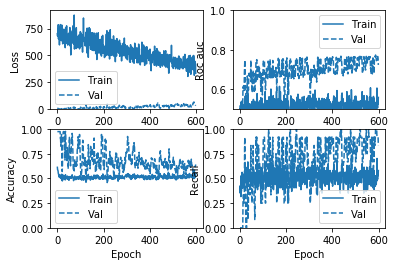

In [23]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(history)

In [24]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
pred = model.predict(dataset_val)

ks:  0.5527522935779816 

threshold:  4.6887585e-19 



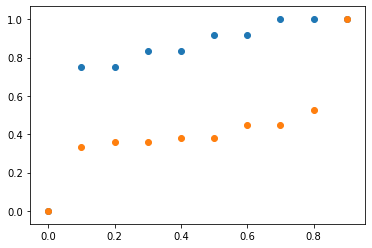

In [25]:
fpr,tpr,thresholds= roc_curve(y_test[0:len(pred)],pred)
ks_value = max(tpr-fpr)
print('ks: ', ks_value, '\n')

thresholds = thresholds[(tpr-fpr).argmax()]
print('threshold: ', thresholds, '\n')
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(x = [x/len(tpr) for x in range(0, len(tpr))], y = tpr)
plt.scatter(x = [x/len(tpr) for x in range(0, len(tpr))], y = fpr)
plt.show()

In [26]:
roc_auc_score(y_test[0:len(pred)],pred)

0.7754204892966361